# Capstone Project Notebook (part 3 of 3)
### by Dimitar Kunev
This notebook will be used as the primary vehicle for my capstone project to cluster and explore the Toronto boroughs.

In [23]:
# set up the libraries
#    this list will grow as I progress through the project
import pandas as pd
import numpy as np
import requests
# import lxml.html as lh
# from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


Solving environment: done

# All requested packages already installed.



In [7]:
# get the geo coded data from previous part
df = pd.read_csv('toronto_geo.csv')
df.drop(columns=['Unnamed: 0', 'Postal Code'], inplace=True)
df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Port Union, Rouge Hill, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [8]:
df.shape

(103, 5)

Data import looks good!

Now, let's get just the Toronto boroughs...

In [9]:
toronto = df[df['Borough'].str.contains('Toronto', case=False, regex=False)].reset_index(drop=True)
toronto.head(20)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
7,M4S,Central Toronto,Davisville,43.704324,-79.388790
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
9,M4V,Central Toronto,"South Hill, Rathnelly, Summerhill West, Deer P...",43.686412,-79.400049


In [10]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto, ON are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto, ON are 43.653963, -79.387207.


In [11]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto['Latitude'], toronto['Longitude'], toronto['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [12]:
toronto.shape

(38, 5)

In [13]:
toronto['Borough'].unique()

array(['East Toronto', 'Central Toronto', 'Downtown Toronto',
       'West Toronto'], dtype=object)

#### Next, I set up FourSquare
(should be invisible in the public version of the notebook)

In [14]:
CLIENT_ID = '___my_id____'
CLIENT_SECRET = '___my_key___'
VERSION = '20180605' # Foursquare API version

In [15]:
radius = 1000 # distance in meters from the focal point
LIMIT = 200  # number of results returned by FourSquare

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
toronto_venues = getNearbyVenues(names=toronto['Neighbourhood'],
                                 latitudes=toronto['Latitude'],
                                 longitudes=toronto['Longitude']
                                )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
South Hill, Rathnelly, Summerhill West, Deer Park, Forest Hill SE
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Regent Park, Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
King, Adelaide, Richmond
Toronto Islands, Harbourfront East, Union Station
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, Yorkville, North Midtown
University of Toronto, Harbord
Kensington Market, Grange Park, Chinatown
Railway Lands, South Niagara, Harbourfront West, Island airport, Bathurst Quay, CN Tower, King and Spadina
Stn A PO Boxes 25 The Esplanade
Underground city, First Canadian Place
Christie
Dovercourt Village, Dufferin
Trinity, Little Portugal
Exhibition Place, Brockton, Parkdale Village
High Park, The 

In [17]:
toronto_venues.shape
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Berczy Park,100,100,100,100,100,100
Business Reply Mail Processing Centre 969 Eastern,48,48,48,48,48,48
"Cabbagetown, St. James Town",39,39,39,39,39,39
Central Bay Street,100,100,100,100,100,100
Christie,100,100,100,100,100,100
Church and Wellesley,100,100,100,100,100,100
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,100,100,100,100,100,100
Davisville North,100,100,100,100,100,100


In [18]:
print('There are {} unique venues across {} unique categories around Toronto, ON.'.format(len(toronto_venues['Venue'].unique()),
                                                                                          len(toronto_venues['Venue Category'].unique())))

There are 1823 unique venues across 272 unique categories around Toronto, ON.


### Explore the Toronto neighbourhoods
First, let's crosstabulate each venue to its respective category. Then, I will aggregate the categories counts by Postal code.

In [19]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()

In [20]:
toronto_grouped.shape

(38, 273)

Note that we get 38 rows (same as in the toronto data frame above) and 272 venue categories as above (+1 column forhte neighbourhood name).

The top 10 most common venues categories for each Postal code are:

In [21]:
top_venues = 10

for hood in toronto_grouped['Neighbourhood']:
    print("---- "+hood+" ----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(top_venues))
    print('\n')

---- Berczy Park ----
                 venue  freq
0          Coffee Shop  0.09
1                Hotel  0.06
2                 Café  0.05
3  Japanese Restaurant  0.04
4             Beer Bar  0.04
5         Cocktail Bar  0.03
6           Restaurant  0.03
7                 Park  0.03
8            Gastropub  0.02
9          Cheese Shop  0.02


---- Business Reply Mail Processing Centre 969 Eastern ----
                venue  freq
0         Coffee Shop  0.08
1                Park  0.08
2             Brewery  0.06
3           Pet Store  0.04
4         Pizza Place  0.04
5       Burrito Place  0.04
6    Sushi Restaurant  0.04
7  Italian Restaurant  0.04
8         Snack Place  0.02
9          Steakhouse  0.02


---- Cabbagetown, St. James Town ----
                 venue  freq
0                 Park  0.08
1          Coffee Shop  0.05
2            Gastropub  0.05
3                 Café  0.05
4      Thai Restaurant  0.05
5                Diner  0.05
6  Japanese Restaurant  0.05
7                

Now, I will run a cluster analysis to group the Postal codes by venue category profile:
* transform the most common categories into a data frame
* determine the optimum number of clusters
* run the cluster analysis
* summarize, interpret and visualize the results

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], top_venues)


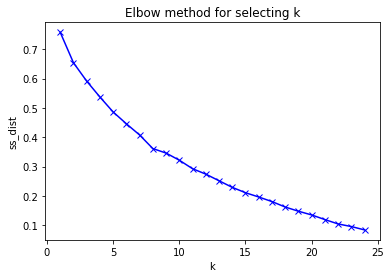

In [30]:
toronto_clustering = toronto_grouped.drop('Neighbourhood', axis=1)
ss_dist = []
K = range(1,25)
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(toronto_clustering)
    ss_dist.append(km.inertia_)

plt.plot(K, ss_dist, 'bx-')
plt.xlabel('k')
plt.ylabel('ss_dist')
plt.title('Elbow method for selecting k')
plt.show()

While there is no strongly displayed elbow, there is a break in hte line at k=8. therefore, 8 clusters were retained.

In [37]:
k=8
km = KMeans(n_clusters=k, random_state=0).fit(toronto_clustering)

neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', km.labels_)

toronto_merged = toronto

# merge toronto_grouped with toronto data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head()

ValueError: cannot insert Cluster Labels, already exists

Let's take a look at the clusters on the map:

In [36]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], 
                                  toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

... and the composition of each cluster is:

### Cluster 1

In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, 
                        toronto_merged.columns[[1] + [2] + [0]
                                               + list(range(6, toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,East Toronto,Studio District,M4M,Coffee Shop,Bar,Café,American Restaurant,Vietnamese Restaurant,Bakery,Diner,Brewery,Italian Restaurant,Arts & Crafts Store
25,Downtown Toronto,"University of Toronto, Harbord",M5S,Café,Bakery,Bar,Vegetarian / Vegan Restaurant,Restaurant,Arts & Crafts Store,Mexican Restaurant,Bookstore,Japanese Restaurant,Burger Joint
26,Downtown Toronto,"Kensington Market, Grange Park, Chinatown",M5T,Café,Vegetarian / Vegan Restaurant,Bar,Bakery,Mexican Restaurant,Coffee Shop,Art Gallery,Ice Cream Shop,French Restaurant,Yoga Studio
30,Downtown Toronto,Christie,M6G,Korean Restaurant,Café,Coffee Shop,Grocery Store,Indian Restaurant,Ice Cream Shop,Cocktail Bar,Japanese Restaurant,Pizza Place,Diner
32,West Toronto,"Trinity, Little Portugal",M6J,Café,Bar,Bakery,Coffee Shop,Restaurant,Cocktail Bar,Italian Restaurant,Asian Restaurant,Pizza Place,Vegetarian / Vegan Restaurant
33,West Toronto,"Exhibition Place, Brockton, Parkdale Village",M6K,Café,Coffee Shop,Bar,Furniture / Home Store,Restaurant,Tibetan Restaurant,Indian Restaurant,Bakery,French Restaurant,Sandwich Place
34,West Toronto,"High Park, The Junction South",M6P,Café,Bar,Coffee Shop,Convenience Store,Italian Restaurant,Park,Fast Food Restaurant,Sushi Restaurant,Thai Restaurant,Pizza Place


### Cluster 2

In [46]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, 
                        toronto_merged.columns[[1] + [2] + [0]
                                               + list(range(6, toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,The Beaches,M4E,Pub,Coffee Shop,Pizza Place,Beach,Breakfast Spot,Park,Japanese Restaurant,Bakery,Bar,Tea Room
1,East Toronto,"The Danforth West, Riverdale",M4K,Greek Restaurant,Coffee Shop,Café,Pub,Fast Food Restaurant,Italian Restaurant,Pizza Place,Ice Cream Shop,Spa,Bakery
2,East Toronto,"The Beaches West, India Bazaar",M4L,Indian Restaurant,Coffee Shop,Beach,Café,Gym,Brewery,Harbor / Marina,Park,Bakery,Burrito Place
5,Central Toronto,Davisville North,M4P,Coffee Shop,Fast Food Restaurant,Italian Restaurant,Café,Pizza Place,Dessert Shop,Sushi Restaurant,Gym,Pharmacy,Ramen Restaurant
6,Central Toronto,North Toronto West,M4R,Skating Rink,Sporting Goods Shop,Italian Restaurant,Coffee Shop,Mexican Restaurant,Café,Diner,Fast Food Restaurant,Restaurant,Deli / Bodega
7,Central Toronto,Davisville,M4S,Coffee Shop,Italian Restaurant,Sushi Restaurant,Café,Pub,Gym,Restaurant,Fast Food Restaurant,Indian Restaurant,Pizza Place
11,Downtown Toronto,"Cabbagetown, St. James Town",M4X,Park,Japanese Restaurant,Thai Restaurant,Coffee Shop,Gastropub,Diner,Café,American Restaurant,Pie Shop,Steakhouse
12,Downtown Toronto,Church and Wellesley,M4Y,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Restaurant,Diner,Park,Sandwich Place,Dance Studio,Gym
14,Downtown Toronto,"Ryerson, Garden District",M5B,Coffee Shop,Clothing Store,Cosmetics Shop,Gastropub,Restaurant,Middle Eastern Restaurant,Tea Room,Fast Food Restaurant,Café,Italian Restaurant
17,Downtown Toronto,Central Bay Street,M5G,Coffee Shop,Ice Cream Shop,Café,Park,Italian Restaurant,Ramen Restaurant,Vegetarian / Vegan Restaurant,Bubble Tea Shop,Gastropub,Burger Joint


### Cluster 3

In [47]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, 
                        toronto_merged.columns[[1] + [2] + [0]
                                               + list(range(6, toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Central Toronto,Lawrence Park,M4N,Café,Bookstore,College Quad,College Gym,Coffee Shop,Park,Gym / Fitness Center,Trail,Zoo,Ethiopian Restaurant


### Cluster 4

In [48]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, 
                        toronto_merged.columns[[1] + [2] + [0]
                                               + list(range(6, toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Downtown Toronto,"Railway Lands, South Niagara, Harbourfront Wes...",M5V,Coffee Shop,Café,Harbor / Marina,Dance Studio,Sculpture Garden,Dog Run,Scenic Lookout,Track,Park,Garden


### Cluster 5

In [49]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, 
                        toronto_merged.columns[[1] + [2] + [0]
                                               + list(range(6, toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Downtown Toronto,St. James Town,M5C,Coffee Shop,Café,Restaurant,Hotel,Cosmetics Shop,Breakfast Spot,Bakery,Seafood Restaurant,Italian Restaurant,Gastropub
16,Downtown Toronto,Berczy Park,M5E,Coffee Shop,Hotel,Café,Japanese Restaurant,Beer Bar,Restaurant,Park,Cocktail Bar,Bakery,Cheese Shop
18,Downtown Toronto,"King, Adelaide, Richmond",M5H,Coffee Shop,Café,Hotel,Theater,Sushi Restaurant,American Restaurant,Asian Restaurant,Japanese Restaurant,Bakery,Thai Restaurant
19,Downtown Toronto,"Toronto Islands, Harbourfront East, Union Station",M5J,Coffee Shop,Hotel,Café,Italian Restaurant,Aquarium,Scenic Lookout,Brewery,Bakery,Park,Baseball Stadium
20,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",M5K,Coffee Shop,Hotel,Café,Steakhouse,Concert Hall,Italian Restaurant,American Restaurant,Restaurant,Pizza Place,Japanese Restaurant
21,Downtown Toronto,"Commerce Court, Victoria Hotel",M5L,Coffee Shop,Café,Hotel,Restaurant,Steakhouse,Gastropub,Beer Bar,Concert Hall,American Restaurant,Japanese Restaurant
28,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,M5W,Coffee Shop,Restaurant,Café,Beer Bar,Japanese Restaurant,Cocktail Bar,Gastropub,Seafood Restaurant,Hotel,Art Gallery
29,Downtown Toronto,"Underground city, First Canadian Place",M5X,Coffee Shop,Café,Hotel,Steakhouse,Restaurant,American Restaurant,Theater,Japanese Restaurant,Asian Restaurant,Bakery


### Cluster 6

In [50]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, 
                        toronto_merged.columns[[1] + [2] + [0]
                                               + list(range(6, toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Central Toronto,"Moore Park, Summerhill East",M4T,Italian Restaurant,Coffee Shop,Pub,Grocery Store,Park,Gym,Pizza Place,Bagel Shop,Café,Sandwich Place
9,Central Toronto,"South Hill, Rathnelly, Summerhill West, Deer P...",M4V,Coffee Shop,Park,Sushi Restaurant,Italian Restaurant,Pub,Pizza Place,Gym / Fitness Center,Bagel Shop,Grocery Store,Sandwich Place
13,Downtown Toronto,"Regent Park, Harbourfront",M5A,Coffee Shop,Café,Italian Restaurant,Restaurant,Bakery,Pub,Gym / Fitness Center,Diner,Breakfast Spot,Park
23,Central Toronto,"Forest Hill North, Forest Hill West",M5P,Café,Gym / Fitness Center,Coffee Shop,Park,Deli / Bodega,Japanese Restaurant,Bakery,Burger Joint,Trail,Bank
31,West Toronto,"Dovercourt Village, Dufferin",M6H,Café,Park,Coffee Shop,Bar,Sushi Restaurant,Restaurant,Italian Restaurant,Brewery,Bakery,Camera Store
35,West Toronto,"Roncesvalles, Parkdale",M6R,Pizza Place,Coffee Shop,Sushi Restaurant,Café,Breakfast Spot,Bar,Thai Restaurant,Bakery,Gym,Eastern European Restaurant
36,West Toronto,"Runnymede, Swansea",M6S,Café,Coffee Shop,Bakery,Pizza Place,Italian Restaurant,Pub,Gastropub,Spa,Park,Sushi Restaurant
37,East Toronto,Business Reply Mail Processing Centre 969 Eastern,M7Y,Park,Coffee Shop,Brewery,Italian Restaurant,Burrito Place,Sushi Restaurant,Pet Store,Pizza Place,Diner,Flea Market


### Cluster 7

In [51]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, 
                        toronto_merged.columns[[1] + [2] + [0]
                                               + list(range(6, toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Central Toronto,Roselawn,M5N,Sushi Restaurant,Bank,Pharmacy,Café,Italian Restaurant,Coffee Shop,Spa,Pet Store,Japanese Restaurant,Gym Pool


### Cluster 8

In [52]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 7, 
                        toronto_merged.columns[[1] + [2] + [0]
                                               + list(range(6, toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Downtown Toronto,Rosedale,M4W,Coffee Shop,Park,Bank,Grocery Store,Sandwich Place,Office,Caribbean Restaurant,Candy Store,BBQ Joint,Japanese Restaurant
